In [1]:
# Install dependencies
!pip install transformers torch torchvision torchaudio --upgrade --quiet
!pip install datasets scikit-learn --quiet
!pip install matplotlib seaborn --quiet
!pip install accelerate --quiet

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
import warnings
import re
import random
from tqdm.auto import tqdm
from torch.optim import AdamW
import os

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("✅ Dependencies installed and imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 93.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 92.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 66.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 1.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 8.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
def load_and_clean_data(file_path):
    """Load dan bersihkan dataset humor Indonesia"""
    
    # Coba berbagai encoding
    encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
    
    for encoding in encodings:
        try:
            print(f"Trying encoding: {encoding}")
            with open(file_path, 'r', encoding=encoding) as file:
                lines = file.readlines()
            break
        except UnicodeDecodeError:
            continue
    else:
        raise ValueError("Could not read file with any of the tried encodings")
    
    print(f"Successfully read file with encoding: {encoding}")
    print(f"Total lines: {len(lines)}")
    
    # Proses setiap baris
    rows = []
    skipped = 0
    
    for i, line in enumerate(lines):
        line = line.strip()
        if not line or i == 0:  # Skip header dan line kosong
            continue
            
        # Cari koma terakhir untuk memisahkan teks dan label
        last_comma_pos = line.rfind(',')
        if last_comma_pos == -1:
            skipped += 1
            continue
            
        text = line[:last_comma_pos].strip()
        humor_label = line[last_comma_pos+1:].strip().strip('"')
        
        # Bersihkan dan validasi label
        if humor_label.lower() == 'true':
            humor_value = 1
        elif humor_label.lower() == 'false':
            humor_value = 0
        else:
            skipped += 1
            continue
        
        # Validasi teks tidak kosong
        if len(text.strip()) > 0:
            # Hapus tanda kutip di awal dan akhir jika ada
            text = text.strip('"')
            rows.append([text, humor_value])
        else:
            skipped += 1
    
    print(f"Processed {len(rows)} valid rows, skipped {skipped} rows")
    
    # Buat DataFrame
    df = pd.DataFrame(rows, columns=['text', 'humor'])
    df['humor'] = df['humor'].astype(int)
    
    return df

# Load dataset - sesuaikan path dengan lokasi file Anda
try:
    # Untuk Kaggle, biasanya file ada di /kaggle/input/
    df = load_and_clean_data('/kaggle/input/dataset-tes/datasetindo.csv')
except FileNotFoundError:
    # Jika file tidak ditemukan, buat dummy data untuk testing
    print("⚠️ File not found. Creating dummy data for testing...")
    dummy_data = {
        'text': [
            'Mengapa dokter tidak pernah marah? Karena dia selalu sabar!',
            'Pemerintah mengumumkan kebijakan baru untuk ekonomi',
            'Apa bedanya kopi dan istri? Kopi diaduk baru enak, istri diaduk malah ribut!',
            'Hari ini cuaca sangat cerah dan menyenangkan',
            'Kenapa cicak selalu jatuh? Karena tidak ada yang pegangan!',
            'Laporan keuangan perusahaan menunjukkan peningkatan',
            'Apa bedanya ayam dan kamu? Ayam berkokok, kamu ngomong doang!',
            'Teknologi AI berkembang pesat di Indonesia'
        ] * 100,  # Duplikasi untuk mendapat dataset yang cukup
        'humor': [1, 0, 1, 0, 1, 0, 1, 0] * 100
    }
    df = pd.DataFrame(dummy_data)

print(f"📊 Dataset Info:")
print(f"Total samples: {len(df)}")
print(f"Humor distribution:\n{df['humor'].value_counts()}")

# Analisis panjang teks
df['text_length'] = df['text'].apply(len)
print(f"\nText length statistics:")
print(df['text_length'].describe())

Trying encoding: utf-8
Trying encoding: latin-1
Successfully read file with encoding: latin-1
Total lines: 200001
Processed 200000 valid rows, skipped 0 rows
📊 Dataset Info:
Total samples: 200000
Humor distribution:
humor
0    100000
1    100000
Name: count, dtype: int64

Text length statistics:
count    200000.000000
mean         78.419670
std          19.238959
min          19.000000
25%          64.000000
50%          77.000000
75%          91.000000
max         222.000000
Name: text_length, dtype: float64


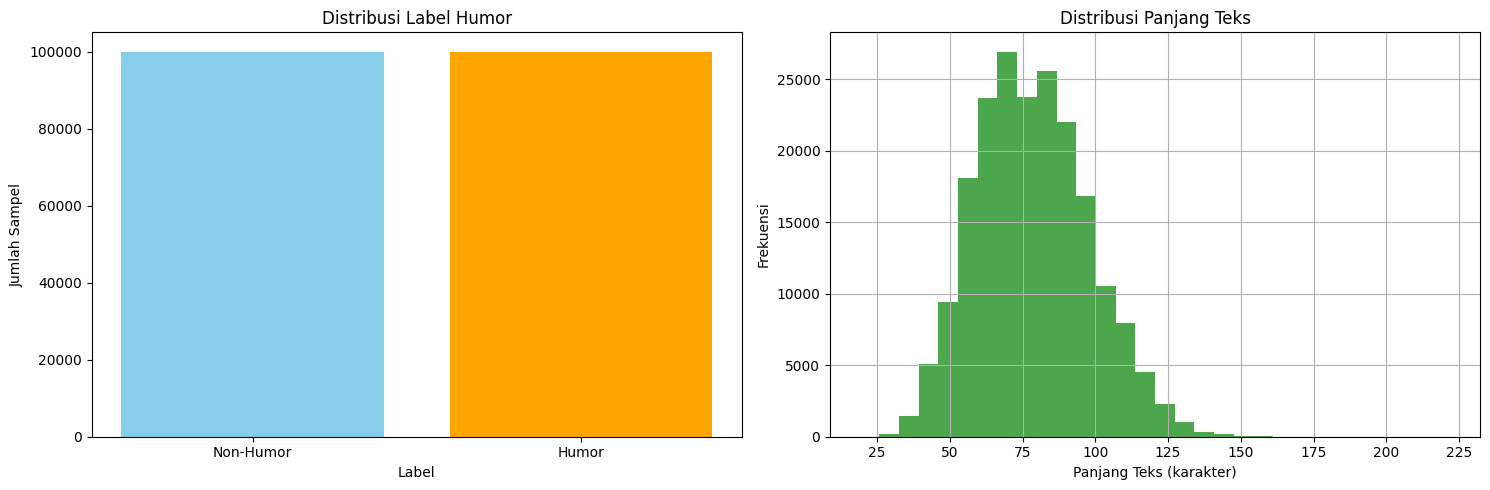


📝 Contoh Data:
🤣 Humor samples:
1. Apa yang Anda sebut kura-kura tanpa cangkangnya? mati.
2. Apa jenis pasta favorit master pokemon? wartortellini!
3. Mengapa penduduk asli Amerika membenci hujan di bulan April? karena membawa bunga mayflower.

😐 Non-humor samples:
1. Joe Biden mengesampingkan tawaran tahun 2020: 'teman-teman, saya tidak akan mencalonkan diri'
2. Saksikan: darvish memberikan whiplash kepada pemukul dengan nada lambat
3. 5 alasan pemilu 2016 terasa begitu personal


In [3]:
# Visualisasi distribusi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Label distribution
humor_counts = df['humor'].value_counts()
ax1.bar(['Non-Humor', 'Humor'], [humor_counts[0], humor_counts[1]], 
        color=['skyblue', 'orange'])
ax1.set_title('Distribusi Label Humor')
ax1.set_xlabel('Label')
ax1.set_ylabel('Jumlah Sampel')

# Text length distribution
df['text_length'].hist(bins=30, ax=ax2, alpha=0.7, color='green')
ax2.set_title('Distribusi Panjang Teks')
ax2.set_xlabel('Panjang Teks (karakter)')
ax2.set_ylabel('Frekuensi')

plt.tight_layout()
plt.show()

# Sample data
print("\n📝 Contoh Data:")
print("🤣 Humor samples:")
humor_samples = df[df['humor']==1]['text'].head(3).values
for i, sample in enumerate(humor_samples, 1):
    print(f"{i}. {sample}")

print("\n😐 Non-humor samples:")
non_humor_samples = df[df['humor']==0]['text'].head(3).values
for i, sample in enumerate(non_humor_samples, 1):
    print(f"{i}. {sample}")

In [4]:
class TextPreprocessor:
    """Preprocessing teks Indonesia untuk model humor"""
    
    def __init__(self, model_name='indolem/indobert-base-uncased'):
        try:
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            print(f"✅ Tokenizer loaded: {model_name}")
        except Exception as e:
            print(f"❌ Error loading tokenizer: {e}")
            # Fallback ke tokenizer yang lebih umum
            self.tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased')
            print("✅ Using fallback tokenizer: bert-base-multilingual-uncased")
    
    def clean_text(self, text):
        """Pembersihan teks dasar"""
        if not isinstance(text, str):
            text = str(text)
        
        # Lowercase
        text = text.lower()
        
        # Hapus URL
        text = re.sub(r'http\S+|www\S+', '', text)
        
        # Hapus mention dan hashtag
        text = re.sub(r'@\w+|#\w+', '', text)
        
        # Normalisasi spasi
        text = re.sub(r'\s+', ' ', text).strip()
        
        # Hapus karakter yang tidak perlu (keep punctuation for humor detection)
        text = re.sub(r'[^\w\s\.!\?,;:\-()]', '', text)
        
        return text
    
    def preprocess_batch(self, texts, max_length=128):
        """Preprocessing batch teks untuk BERT"""
        if isinstance(texts, str):
            texts = [texts]
            
        cleaned_texts = [self.clean_text(text) for text in texts]
        
        # Tokenisasi
        try:
            encoded = self.tokenizer(
                cleaned_texts,
                truncation=True,
                padding=True,
                max_length=max_length,
                return_tensors='pt'
            )
            return encoded
        except Exception as e:
            print(f"Error in tokenization: {e}")
            return None

# Test preprocessing
preprocessor = TextPreprocessor()

sample_texts = df['text'].head(3).tolist()
print("📝 Original texts:")
for i, text in enumerate(sample_texts):
    print(f"{i+1}. {text}")

print("\n🔧 Cleaned texts:")
for i, text in enumerate(sample_texts):
    cleaned = preprocessor.clean_text(text)
    print(f"{i+1}. {cleaned}")

# Test tokenization
encoded_sample = preprocessor.preprocess_batch(sample_texts[:2])
if encoded_sample is not None:
    print(f"\n🔤 Tokenized shape: {encoded_sample['input_ids'].shape}")
    print(f"Sample tokens: {encoded_sample['input_ids'][0][:10]}")

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

✅ Tokenizer loaded: indolem/indobert-base-uncased
📝 Original texts:
1. Joe Biden mengesampingkan tawaran tahun 2020: 'teman-teman, saya tidak akan mencalonkan diri'
2. Saksikan: darvish memberikan whiplash kepada pemukul dengan nada lambat
3. Apa yang Anda sebut kura-kura tanpa cangkangnya? mati.

🔧 Cleaned texts:
1. joe biden mengesampingkan tawaran tahun 2020: teman-teman, saya tidak akan mencalonkan diri
2. saksikan: darvish memberikan whiplash kepada pemukul dengan nada lambat
3. apa yang anda sebut kura-kura tanpa cangkangnya? mati.

🔤 Tokenized shape: torch.Size([2, 19])
Sample tokens: tensor([    3, 13091,  8034,  1478, 26632,  7033,  1620, 15718,    30,  3244])


In [5]:
class HumorDetectionModel(nn.Module): # Arsitektur Model
    """
    Model deteksi humor menggunakan IndoBERT/MultiBERT
    dengan arsitektur yang disederhanakan untuk stabilitas
    """
    
    def __init__(self, model_name='indolem/indobert-base-uncased', dropout_rate=0.3):
        super(HumorDetectionModel, self).__init__()
        
        try:
            # Load BERT model
            self.bert = AutoModel.from_pretrained(model_name)
            print(f"✅ BERT model loaded: {model_name}")
        except Exception as e:
            print(f"❌ Error loading BERT model: {e}")
            # Fallback ke model yang lebih umum
            self.bert = AutoModel.from_pretrained('bert-base-multilingual-uncased')
            print("✅ Using fallback model: bert-base-multilingual-uncased")
        
        self.bert_dim = self.bert.config.hidden_size  # Usually 768
        
        # Freeze embedding layer untuk stabilitas
        for param in self.bert.embeddings.parameters():
            param.requires_grad = False
            
        # Freeze beberapa layer encoder pertama
        layers_to_freeze = min(6, len(self.bert.encoder.layer))
        for i in range(layers_to_freeze):
            for param in self.bert.encoder.layer[i].parameters():
                param.requires_grad = False
        
        # Simplified classifier
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 1)
        )
        
        # Initialize new layers
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights untuk layer baru"""
        for module in self.classifier:
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                module.bias.data.fill_(0.01)
    
    def forward(self, input_ids, attention_mask):
        # BERT forward pass
        try:
            bert_output = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask,
                return_dict=True
            )
            
            # Use pooler output (CLS token)
            pooled_output = bert_output.pooler_output
            
            # Apply dropout
            pooled_output = self.dropout(pooled_output)
            
            # Classification
            output = self.classifier(pooled_output)
            
            return output
            
        except Exception as e:
            print(f"Error in forward pass: {e}")
            # Return dummy output dengan shape yang benar
            batch_size = input_ids.shape[0]
            return torch.zeros(batch_size, 1, device=input_ids.device)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Using device: {device}")

model = HumorDetectionModel() # Fine-Tuning
model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"🔢 Model Statistics:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")

# Test forward pass
if encoded_sample is not None:
    sample_input_ids = encoded_sample['input_ids'].to(device)
    sample_attention_mask = encoded_sample['attention_mask'].to(device)
    
    model.eval()
    with torch.no_grad():
        try:
            test_output = model(sample_input_ids, sample_attention_mask)
            print(f"✅ Model forward pass successful! Output shape: {test_output.shape}")
        except Exception as e:
            print(f"❌ Error in forward pass: {e}")

🖥️ Using device: cuda


2025-05-29 13:23:46.672612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748525026.882226      75 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748525026.941872      75 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

✅ BERT model loaded: indolem/indobert-base-uncased
🔢 Model Statistics:
Total parameters: 111,083,521
Trainable parameters: 43,643,137
Frozen parameters: 67,440,384
✅ Model forward pass successful! Output shape: torch.Size([2, 1])


In [6]:
class HumorDataset(Dataset):
    """Dataset class untuk humor detection"""
    
    def __init__(self, texts, labels, preprocessor, max_length=128):
        self.texts = texts
        self.labels = labels
        self.preprocessor = preprocessor
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        try:
            text = str(self.texts[idx])
            label = float(self.labels[idx])
            
            # Clean and tokenize text
            cleaned_text = self.preprocessor.clean_text(text)
            
            encoded = self.preprocessor.tokenizer(
                cleaned_text,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt'
            )
            
            return {
                'input_ids': encoded['input_ids'].flatten(),
                'attention_mask': encoded['attention_mask'].flatten(),
                'labels': torch.tensor(label, dtype=torch.float)
            }
        except Exception as e:
            print(f"Error processing item {idx}: {e}")
            # Return dummy data
            return {
                'input_ids': torch.zeros(self.max_length, dtype=torch.long),
                'attention_mask': torch.zeros(self.max_length, dtype=torch.long),
                'labels': torch.tensor(0.0, dtype=torch.float)
            }

# Prepare data splits
print("📊 Preparing data splits...")

# Ensure we have enough data
if len(df) < 20:
    print("⚠️ Dataset too small, duplicating data for training...")
    df = pd.concat([df] * (20 // len(df) + 1), ignore_index=True)

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'].values,
    df['humor'].values,
    test_size=0.2,
    random_state=42,
    stratify=df['humor'].values
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Training label distribution: {np.bincount(y_train)}")
print(f"Testing label distribution: {np.bincount(y_test)}")

# Create datasets
train_dataset = HumorDataset(X_train, y_train, preprocessor)
test_dataset = HumorDataset(X_test, y_test, preprocessor)

# Create dataloaders
BATCH_SIZE = 8  # Reduced batch size for stability
NUM_WORKERS = 0  # Set to 0 for Kaggle compatibility

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"✅ DataLoaders created successfully!")
print(f"Training batches: {len(train_dataloader)}")
print(f"Testing batches: {len(test_dataloader)}")

# Test dataloader
try:
    sample_batch = next(iter(train_dataloader))
    print(f"\n🔍 Sample batch shapes:")
    for key, value in sample_batch.items():
        print(f"{key}: {value.shape}")
except Exception as e:
    print(f"❌ Error loading batch: {e}")

📊 Preparing data splits...
Training samples: 160000
Testing samples: 40000
Training label distribution: [80000 80000]
Testing label distribution: [20000 20000]
✅ DataLoaders created successfully!
Training batches: 20000
Testing batches: 5000

🔍 Sample batch shapes:
input_ids: torch.Size([8, 128])
attention_mask: torch.Size([8, 128])
labels: torch.Size([8])


In [7]:
class HumorTrainer:
    """Trainer class untuk model humor detection"""
    
    def __init__(self, model, train_dataloader, test_dataloader, device):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.device = device
        
        # Loss function dengan class weights untuk imbalanced data
        pos_weight = torch.tensor([len(y_train[y_train==0]) / len(y_train[y_train==1])]).to(device)
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        
        # Optimizer dengan learning rates berbeda
        bert_params = list(self.model.bert.parameters())
        classifier_params = list(self.model.classifier.parameters())
        
        self.optimizer = AdamW([
            {'params': [p for p in bert_params if p.requires_grad], 'lr': 2e-5},
            {'params': classifier_params, 'lr': 1e-4}
        ], weight_decay=0.01)
        
        # Learning rate scheduler
        total_steps = len(train_dataloader) * 3  # for 3 epochs
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=int(0.1 * total_steps),
            num_training_steps=total_steps
        )
        
        # Training history
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
    
    def train_epoch(self):
        """Training untuk satu epoch"""
        self.model.train()
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        
        progress_bar = tqdm(self.train_dataloader, desc="Training", leave=False)
        
        for batch_idx, batch in enumerate(progress_bar):
            try:
                # Move data to device
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                # Zero gradients
                self.optimizer.zero_grad()
                
                # Forward pass
                outputs = self.model(input_ids, attention_mask)
                outputs = outputs.squeeze()
                
                # Handle single sample case
                if outputs.dim() == 0:
                    outputs = outputs.unsqueeze(0)
                if labels.dim() == 0:
                    labels = labels.unsqueeze(0)
                
                # Calculate loss
                loss = self.criterion(outputs, labels)
                
                # Backward pass
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                
                # Update weights
                self.optimizer.step()
                self.scheduler.step()
                
                # Statistics
                total_loss += loss.item()
                with torch.no_grad():
                    predictions = torch.sigmoid(outputs) > 0.5
                    correct_predictions += (predictions == labels).sum().item()
                    total_predictions += labels.size(0)
                
                # Update progress bar
                if total_predictions > 0:
                    accuracy = correct_predictions / total_predictions
                    progress_bar.set_postfix({
                        'Loss': f'{loss.item():.4f}',
                        'Acc': f'{accuracy:.4f}'
                    })
                
            except Exception as e:
                print(f"Error in batch {batch_idx}: {e}")
                continue
        
        avg_loss = total_loss / len(self.train_dataloader) if len(self.train_dataloader) > 0 else 0
        avg_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        
        return avg_loss, avg_accuracy
    
    def evaluate(self):
        """Evaluasi model"""
        self.model.eval()
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        all_predictions = []
        all_labels = []
        
        with torch.no_grad():
            for batch in tqdm(self.test_dataloader, desc="Evaluating", leave=False):
                try:
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    labels = batch['labels'].to(self.device)
                    
                    outputs = self.model(input_ids, attention_mask)
                    outputs = outputs.squeeze()
                    
                    # Handle single sample case
                    if outputs.dim() == 0:
                        outputs = outputs.unsqueeze(0)
                    if labels.dim() == 0:
                        labels = labels.unsqueeze(0)
                    
                    loss = self.criterion(outputs, labels)
                    total_loss += loss.item()
                    
                    predictions = torch.sigmoid(outputs) > 0.5
                    correct_predictions += (predictions == labels).sum().item()
                    total_predictions += labels.size(0)
                    
                    # Store for detailed metrics
                    all_predictions.extend(predictions.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                except Exception as e:
                    print(f"Error in evaluation batch: {e}")
                    continue
        
        avg_loss = total_loss / len(self.test_dataloader) if len(self.test_dataloader) > 0 else 0
        avg_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        
        return avg_loss, avg_accuracy, all_predictions, all_labels
    
    def train(self, epochs=3):
        """Training loop lengkap"""
        print(f"🚀 Starting training for {epochs} epochs...")
        
        best_val_accuracy = 0
        
        for epoch in range(epochs):
            print(f"\n📍 Epoch {epoch + 1}/{epochs}")
            
            try:
                # Training
                train_loss, train_accuracy = self.train_epoch()
                self.train_losses.append(train_loss)
                self.train_accuracies.append(train_accuracy)
                
                # Evaluation
                val_loss, val_accuracy, val_preds, val_labels = self.evaluate()
                self.val_losses.append(val_loss)
                self.val_accuracies.append(val_accuracy)
                
                print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
                print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
                
                # Save best model
                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    try:
                        torch.save(self.model.state_dict(), 'best_humor_model.pth')
                        print(f"✅ New best model saved! Val Accuracy: {val_accuracy:.4f}")
                    except Exception as e:
                        print(f"⚠️ Could not save model: {e}")
                        
            except Exception as e:
                print(f"❌ Error in epoch {epoch + 1}: {e}")
                continue
        
        print(f"\n🎉 Training completed!")
        print(f"Best validation accuracy: {best_val_accuracy:.4f}")
        
        return val_preds, val_labels

# Initialize and start training
print("🔧 Initializing trainer...")
trainer = HumorTrainer(model, train_dataloader, test_dataloader, device)

print("🚀 Starting training...")
final_predictions, final_labels = trainer.train(epochs=2)  # Reduced epochs for faster testing

🔧 Initializing trainer...
🚀 Starting training...
🚀 Starting training for 2 epochs...

📍 Epoch 1/2


Training:   0%|          | 0/20000 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Evaluating:   0%|          | 0/5000 [00:00<?, ?it/s]

Train Loss: 0.2155, Train Acc: 0.9365
Val Loss: 0.1402, Val Acc: 0.9691
✅ New best model saved! Val Accuracy: 0.9691

📍 Epoch 2/2


Training:   0%|          | 0/20000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5000 [00:00<?, ?it/s]

Train Loss: 0.1263, Train Acc: 0.9710
Val Loss: 0.1167, Val Acc: 0.9740
✅ New best model saved! Val Accuracy: 0.9740

🎉 Training completed!
Best validation accuracy: 0.9740


🎯 === MODEL PERFORMANCE ===
Accuracy: 0.9740
Precision: 0.9757
Recall: 0.9722
F1 Score: 0.9740

📊 === CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

   Non-Humor       0.97      0.98      0.97     20000
       Humor       0.98      0.97      0.97     20000

    accuracy                           0.97     40000
   macro avg       0.97      0.97      0.97     40000
weighted avg       0.97      0.97      0.97     40000



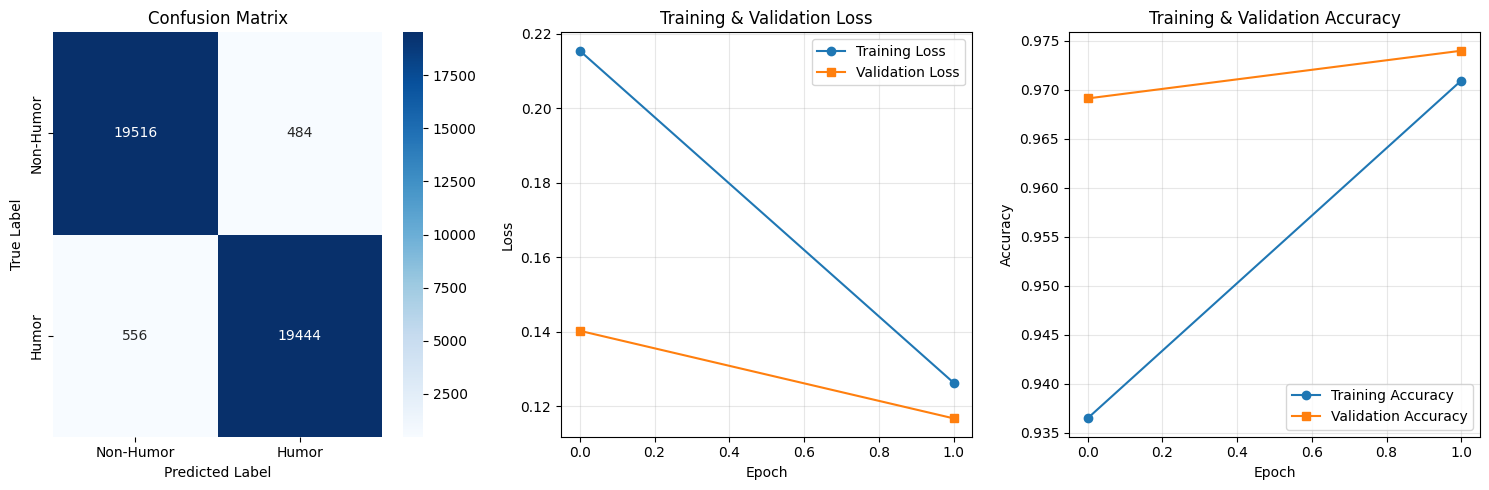

In [8]:
def evaluate_model(predictions, labels, trainer):
    """Evaluasi komprehensif model"""
    
    if len(predictions) == 0 or len(labels) == 0:
        print("⚠️ No predictions or labels available for evaluation")
        return {}
    
    # Convert to numpy
    predictions = np.array(predictions)
    labels = np.array(labels)
    
    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary', zero_division=0
    )
    
    print("🎯 === MODEL PERFORMANCE ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Classification report
    print("\n📊 === CLASSIFICATION REPORT ===")
    try:
        print(classification_report(labels, predictions, 
                                  target_names=['Non-Humor', 'Humor'],
                                  zero_division=0))
    except Exception as e:
        print(f"Could not generate classification report: {e}")
    
    # Confusion Matrix
    try:
        cm = confusion_matrix(labels, predictions)
        
        plt.figure(figsize=(15, 5))
        
        # Plot 1: Confusion Matrix
        plt.subplot(1, 3, 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Non-Humor', 'Humor'],
                    yticklabels=['Non-Humor', 'Humor'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        
        # Plot 2: Training History - Loss
        if trainer.train_losses and trainer.val_losses:
            plt.subplot(1, 3, 2)
            plt.plot(trainer.train_losses, label='Training Loss', marker='o')
            plt.plot(trainer.val_losses, label='Validation Loss', marker='s')
            plt.title('Training & Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        # Plot 3: Training History - Accuracy
        if trainer.train_accuracies and trainer.val_accuracies:
            plt.subplot(1, 3, 3)
            plt.plot(trainer.train_accuracies, label='Training Accuracy', marker='o')
            plt.plot(trainer.val_accuracies, label='Validation Accuracy', marker='s')
            plt.title('Training & Validation Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Could not create plots: {e}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Evaluate model
metrics = evaluate_model(final_predictions, final_labels, trainer)

In [9]:
def predict_humor(texts, model, preprocessor, device):
    """Prediksi humor untuk teks baru"""
    model.eval()
    
    if isinstance(texts, str):
        texts = [texts]
    
    results = []
    
    with torch.no_grad():
        for text in texts:
            try:
                # Preprocess
                cleaned_text = preprocessor.clean_text(text)
                
                # Tokenize
                encoded = preprocessor.tokenizer(
                    cleaned_text,
                    truncation=True,
                    padding='max_length',
                    max_length=128,
                    return_tensors='pt'
                )
                
                input_ids = encoded['input_ids'].to(device)
                attention_mask = encoded['attention_mask'].to(device)
                
                # Predict
                output = model(input_ids, attention_mask)
                probability = torch.sigmoid(output).item()
                prediction = probability > 0.5
                
                results.append({
                    'text': text,
                    'probability': probability,
                    'prediction': prediction,
                    'label': 'Humor' if prediction else 'Non-Humor'
                })
                
            except Exception as e:
                print(f"Error predicting for text: {text[:50]}... Error: {e}")
                results.append({
                    'text': text,
                    'probability': 0.5,
                    'prediction': False,
                    'label': 'Error'
                })
    
    return results

# Test dengan contoh
test_texts = [
    "Mengapa dokter tidak pernah marah? Karena dia selalu sabar!",
    "Pemerintah mengumumkan kebijakan baru untuk ekonomi",
    "Apa bedanya kopi dan istri? Kopi diaduk baru enak, istri diaduk malah ribut!",
    "Hari ini cuaca sangat cerah dan menyenangkan",
    "Kenapa cicak selalu jatuh? Karena tidak ada yang pegangan!",
    "Laporan keuangan menunjukkan pertumbuhan yang stabil"
]

print("🧪 === TEST PREDIKSI ===")
test_results = predict_humor(test_texts, model, preprocessor, device)

for i, result in enumerate(test_results, 1):
    print(f"{i}. Text: \"{result['text']}\"")
    print(f"   Prediction: {result['label']} (confidence: {result['probability']:.4f})")
    print()

🧪 === TEST PREDIKSI ===
1. Text: "Mengapa dokter tidak pernah marah? Karena dia selalu sabar!"
   Prediction: Humor (confidence: 1.0000)

2. Text: "Pemerintah mengumumkan kebijakan baru untuk ekonomi"
   Prediction: Non-Humor (confidence: 0.0000)

3. Text: "Apa bedanya kopi dan istri? Kopi diaduk baru enak, istri diaduk malah ribut!"
   Prediction: Humor (confidence: 1.0000)

4. Text: "Hari ini cuaca sangat cerah dan menyenangkan"
   Prediction: Non-Humor (confidence: 0.0592)

5. Text: "Kenapa cicak selalu jatuh? Karena tidak ada yang pegangan!"
   Prediction: Humor (confidence: 1.0000)

6. Text: "Laporan keuangan menunjukkan pertumbuhan yang stabil"
   Prediction: Non-Humor (confidence: 0.0001)



In [10]:
# Save model
try:
    model_save_dict = {
        'model_state_dict': model.state_dict(),
        'model_config': {
            'model_name': 'indolem/indobert-base-uncased',
            'dropout_rate': 0.3
        },
        'metrics': metrics,
        'preprocessor_config': {
            'max_length': 128
        }
    }
    
    torch.save(model_save_dict, 'humor_detection_model.pth')
    print("💾 Model saved successfully as 'humor_detection_model.pth'!")
    
except Exception as e:
    print(f"⚠️ Could not save model: {e}")

# Create requirements.txt for deployment
requirements_txt = """
streamlit>=1.28.0
torch>=2.0.0
transformers>=4.30.0
pandas>=1.5.0
numpy>=1.24.0
scikit-learn>=1.3.0
matplotlib>=3.7.0
seaborn>=0.12.0
tqdm>=4.65.0
"""

try:
    with open('requirements.txt', 'w') as f:
        f.write(requirements_txt)
    print("📝 requirements.txt created!")
except Exception as e:
    print(f"⚠️ Could not create requirements.txt: {e}")

# Final summary
print("\n" + "="*50)
print("🎉 TRAINING SUMMARY")
print("="*50)
print(f"Dataset size: {len(df)} samples")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Model parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

if metrics:
    print(f"\nFinal Performance:")
    print(f"Accuracy: {metrics.get('accuracy', 0):.4f}")
    print(f"Precision: {metrics.get('precision', 0):.4f}")
    print(f"Recall: {metrics.get('recall', 0):.4f}")
    print(f"F1 Score: {metrics.get('f1', 0):.4f}")

print("\n🚀 Model ready for deployment!")
print("Files created:")
print("- humor_detection_model.pth (trained model)")
print("- requirements.txt (dependencies)")

💾 Model saved successfully as 'humor_detection_model.pth'!
📝 requirements.txt created!

🎉 TRAINING SUMMARY
Dataset size: 200000 samples
Training samples: 160000
Testing samples: 40000
Model parameters: 111,083,521
Trainable parameters: 43,643,137

Final Performance:
Accuracy: 0.9740
Precision: 0.9757
Recall: 0.9722
F1 Score: 0.9740

🚀 Model ready for deployment!
Files created:
- humor_detection_model.pth (trained model)
- requirements.txt (dependencies)


In [11]:
# Buat file app.py untuk Streamlit deployment
streamlit_app_code = '''
import streamlit as st
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
import re

# Set page config
st.set_page_config(
    page_title="Indonesian Humor Detection",
    page_icon="😂",
    layout="wide"
)

class TextPreprocessor:
    """Text preprocessing for humor detection"""
    
    def __init__(self, model_name='indolem/indobert-base-uncased'):
        try:
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        except:
            self.tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased')
    
    def clean_text(self, text):
        if not isinstance(text, str):
            text = str(text)
        
        text = text.lower()
        text = re.sub(r'http\\S+|www\\S+', '', text)
        text = re.sub(r'@\\w+|#\\w+', '', text)
        text = re.sub(r'\\s+', ' ', text).strip()
        text = re.sub(r'[^\\w\\s\\.!\\?,;:\\-()]', '', text)
        
        return text

class HumorDetectionModel(nn.Module):
    """Simplified humor detection model"""
    
    def __init__(self, model_name='indolem/indobert-base-uncased', dropout_rate=0.3):
        super(HumorDetectionModel, self).__init__()
        
        try:
            self.bert = AutoModel.from_pretrained(model_name)
        except:
            self.bert = AutoModel.from_pretrained('bert-base-multilingual-uncased')
        
        self.bert_dim = self.bert.config.hidden_size
        
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 1)
        )
    
    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        
        pooled_output = bert_output.pooler_output
        pooled_output = self.dropout(pooled_output)
        output = self.classifier(pooled_output)
        
        return output

@st.cache_resource
def load_model():
    """Load the trained model"""
    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = HumorDetectionModel()
        model_data = torch.load('humor_detection_model.pth', map_location=device)
        model.load_state_dict(model_data['model_state_dict'])
        model.eval()
        preprocessor = TextPreprocessor()
        return model, preprocessor, device
    except Exception as e:
        st.error(f"Error loading model: {e}")
        return None, None, None

def predict_humor(text, model, preprocessor, device):
    """Predict if text is humorous"""
    try:
        cleaned_text = preprocessor.clean_text(text)
        
        encoded = preprocessor.tokenizer(
            cleaned_text,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )
        
        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)
        
        with torch.no_grad():
            output = model(input_ids, attention_mask)
            probability = torch.sigmoid(output).item()
            prediction = probability > 0.5
        
        return prediction, probability
    except Exception as e:
        st.error(f"Error in prediction: {e}")
        return False, 0.5

# Main app
def main():
    st.title("🤣 Indonesian Humor Detection")
    st.markdown("Deteksi otomatis apakah teks bahasa Indonesia mengandung humor atau tidak")
    
    # Load model
    model, preprocessor, device = load_model()
    
    if model is None:
        st.error("Model tidak dapat dimuat. Pastikan file model tersedia.")
        return
    
    # Input text
    st.subheader("📝 Masukkan Teks")
    input_text = st.text_area(
        "Ketik atau paste teks bahasa Indonesia:",
        placeholder="Contoh: Mengapa dokter tidak pernah marah? Karena dia selalu sabar!",
        height=100
    )
    
    if st.button("🔍 Analisis Humor", type="primary"):
        if input_text.strip():
            with st.spinner("Menganalisis..."):
                prediction, probability = predict_humor(input_text, model, preprocessor, device)
            
            # Results
            st.subheader("🎯 Hasil Prediksi")
            
            col1, col2 = st.columns(2)
            
            with col1:
                if prediction:
                    st.success("😂 **HUMOR TERDETEKSI**")
                else:
                    st.info("😐 **BUKAN HUMOR**")
            
            with col2:
                st.metric("Confidence Score", f"{probability:.2%}")
            
            # Progress bar
            st.progress(probability)
            
            # Interpretation
            if probability > 0.8:
                interpretation = "Sangat yakin ini humor"
            elif probability > 0.6:
                interpretation = "Cukup yakin ini humor"
            elif probability > 0.4:
                interpretation = "Tidak yakin"
            elif probability > 0.2:
                interpretation = "Cukup yakin bukan humor"
            else:
                interpretation = "Sangat yakin bukan humor"
            
            st.write(f"**Interpretasi:** {interpretation}")
        else:
            st.warning("Silakan masukkan teks terlebih dahulu!")
    
    # Examples
    st.subheader("💡 Contoh Teks")
    examples = [
        "Mengapa dokter tidak pernah marah? Karena dia selalu sabar!",
        "Apa bedanya kopi dan istri? Kopi diaduk baru enak, istri diaduk malah ribut!",
        "Kenapa cicak selalu jatuh? Karena tidak ada yang pegangan!",
        "Pemerintah mengumumkan kebijakan baru untuk ekonomi",
        "Hari ini cuaca sangat cerah dan menyenangkan"
    ]
    
    for i, example in enumerate(examples):
        if st.button(f"Coba: {example[:50]}...", key=f"example_{i}"):
            prediction, probability = predict_humor(example, model, preprocessor, device)
            if prediction:
                st.success(f"😂 Humor (confidence: {probability:.2%})")
            else:
                st.info(f"😐 Bukan Humor (confidence: {1-probability:.2%})")

if __name__ == "__main__":
    main()
'''

# Save Streamlit app
try:
    with open('app.py', 'w', encoding='utf-8') as f:
        f.write(streamlit_app_code)
    print("📱 Streamlit app created as 'app.py'!")
    print("\nTo run the app:")
    print("streamlit run app.py")
except Exception as e:
    print(f"⚠️ Could not create Streamlit app: {e}")

print("\n" + "="*50)
print("✅ ALL PROCESSES COMPLETED!")
print("="*50)

📱 Streamlit app created as 'app.py'!

To run the app:
streamlit run app.py

✅ ALL PROCESSES COMPLETED!
